In [2]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from Lib import *

# Introduction

In this file, we implement the Easy21 game and using Monte Carlo control, Temperol difference (TD) control and Linear Function Approximation (LFA) with TD control to train our agent to play the game. The setup of this game is from https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf. For more details, you can consult David Silver's Reinforcement Learning course at UCL https://www.davidsilver.uk/ .

All functions and classes are defined in the python script Lib.py.


# Environment

In this part, we test our implementation of the environment. The rule of the game is defined as
1. The game is played with an infinite deck of cards (i.e. cards are sampled with replacement)

2. Each draw from the deck results in a value between 1 and 10 (uniformly
distributed) with a colour of red (probability 1/3) or black (probability
2/3).

3. There are no aces or picture (face) cards in this game

4. At the start of the game both the player and the dealer draw one black
card (fully observed)

5. Each turn the player may either stick or hit

6. If the player hits then she draws another card from the deck

7. If the player sticks she receives no further cards

8. The values of the player’s cards are added (black cards) or subtracted (red
cards)

9. If the player’s sum exceeds 21, or becomes less than 1, then she “goes
bust” and loses the game (reward -1)

10. If the player sticks then the dealer starts taking turns. The dealer always
sticks on any sum of 17 or greater, and hits otherwise. If the dealer goes
bust, then the player wins; otherwise, the outcome – win (reward +1),
lose (reward -1), or draw (reward 0) – is the player with the largest sum.

## Test of environment

In [11]:
#Let's test one round of game with random action
testEnv = Environment()
actionSpace = ['Hit', 'Stick']

print("Dealer's first card is:", testEnv.dealerFirst)
print("Player's first card is:", testEnv.playerSum)
while testEnv.playerSum:
    action = random.choice((0, 1))
    testEnv.step(action)
    print("############### Action made. #####################")
    print("Player's action is", actionSpace[action])
    print("Player's current is:", testEnv.playerSum)
    print('############## This round ends. ##################')
print("Game ends. The reward is:", testEnv.reward)

Dealer's first card is: 1
Player's first card is: 5
############### Action made. #####################
Player's action is Hit
Player's current is: 7
############## This round ends. ##################
############### Action made. #####################
Player's action is Hit
Player's current is: 4
############## This round ends. ##################
############### Action made. #####################
Player's action is Stick
Player's current is: False
############## This round ends. ##################
Game ends. The reward is: 1


In [12]:
# Let's try to restart the game
testEnv.restart()
print("Dealer's first card for the new game is:", testEnv.dealerFirst)
print("Player's first card for the new game is:", testEnv.playerSum)

Dealer's first card for the new game is: 2
Player's first card for the new game is: 9


# Monte Carlo Control

## A little bit explanation

The action-value function $Q_\pi(s,a)$ given policy $\pi$ is defined as the expected rewards starting from the state-action pair $(s,a)$, i.e. $Q_\pi(s,a) = \mathbb{E}_\pi(G|s,a)$. The optimal action-value function $Q_*(s,a)$ is the maximum action-value function over all policies, i.e. $Q_*(s,a) = \max_\pi Q_\pi(s,a)$.
The MC control is inspired by the definition of action-value functions. For each episode $\{(s_1, a_1, r_1), (s_2, a_2, r_2),...\}$, we update the action-value function $\delta Q(s_t,a_t) = \alpha\Big[G_t - Q(s_t, a_t)\Big]$ where $\alpha$ is the learning rate and $G_t = \sum_{i=t}^\infty \gamma^{i-t}r_i$. We use $\epsilon$-greedy policy rule to draw our samplings and update the action-value function online after each episode. The algorithm is given as
    
    Initialize Q(s,a), N(s,a),
    Repeat (for each episode):
        Sample episode using $\epsilon$-greedy policy
        Repeat (for each step in episode):
            N(s_t,a_t)<-> N(s_t,a_t) + 1,
            Q(s_t, a_t)<- Q(s_t,a_t) + 1/N(s_t, a_t)*[G_t - Q(s_t,a_t)]
        Until the episode terminates

Here, we choose $\epsilon = \frac{N_0}{N_0 + \sum_a N(s,a)}$ in the $\epsilon$-greedy policy. In this section, we implement the MC control agent. 


        
        
 

## Experiment

In [13]:
testMC = MCagent(Environment())

In [15]:
# We train our MC agent for 10^7 episodes
testMC.train(10000000)

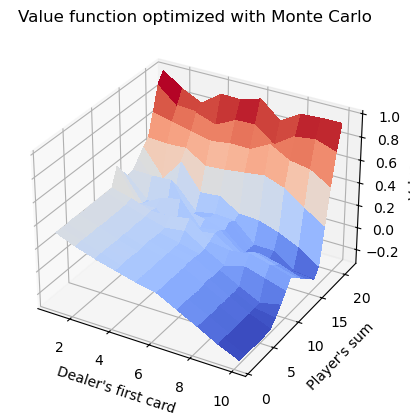

In [31]:
## Here we plot the value function for all possible state we are in.

## In order to have the a clearer graph, we transpose the value function to plot.
V_MC = np.transpose(testMC.get_V())

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(1,11)
Y = np.arange(1,22)
X, Y = np.meshgrid(X, Y)

## Plot the surface.
ax.set_xlabel("Dealer's first card")
ax.set_ylabel("Player's sum")
ax.set_zlabel('Value')
ax.title.set_text('Value function optimized with Monte Carlo')
ax.plot_surface(X, Y, V_MC,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


<Axes: xlabel="Player' sum", ylabel="Dealer's first card">

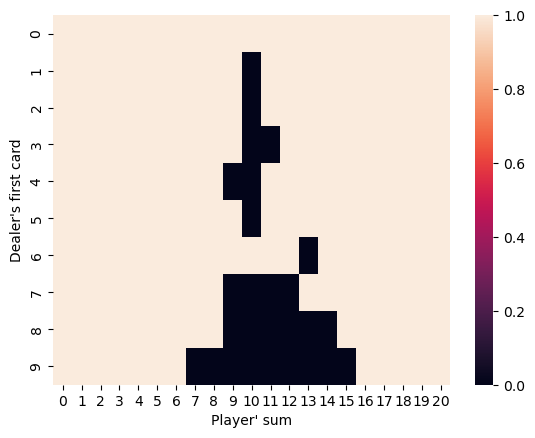

In [25]:
# Here we plot the action map based on greedy policy. Note 0 means hit and 1 means stick.
actMC = np.zeros((10,21))
for i in range(10):
    for j in range(21):
        actMC[i,j] = np.argmax(testMC.Q[i,j])

ax = sns.heatmap(actMC)
ax.set(xlabel = "Player' sum", ylabel = "Dealer's first card")
ax

# TD Control (Sarsa)

## A little bit explanation

Given the defnition of action-value function $Q_*(s,a)$, we can write down the Bellman optimality equation
$$
Q_*(s,a) = r_s^a + \gamma\sum_{s'}P_{ss'}^a\max_{a'}Q_*(s',a').
$$
The vanilla TD control is inspired by the Bellman optimality equation and update the action-value function iteratively by the chosing the best next step and sampling the step after it.
$$
Q(s,a) \leftarrow Q(s,a) + \alpha\Big[r_s^a + \gamma Q(s', a') - Q(s,a)\Big],
$$
where $a'$ is from sampling.

The TD($\lambda$) generalize the vanilla TD control. If we define the $n$-step TD return as $q_t^{(n)} = \sum_{i=t}^{t+n-1} \gamma^{i-t}r_t + \gamma^n Q(s_{t+n}, a_{t+n})$. 
We now define $\lambda$ return as $q_t^\lambda = (1-\lambda)\sum_{n=1}^\infty \lambda^{n-1}q_t^{(n)}$, which means, for each step of sampling, we give it a dicount factor $\lambda$. The TD($\lambda$) is then given by the update
$$
Q(s,a) \leftarrow Q(s,a) + \alpha\Big[q_t^\lambda - Q(s,a)\Big].
$$
The vanilla TD, or TD($0$) is updated with $\lambda = 0$. The above explanation is from the forward-view. The TD($\lambda$) also have a backward view explanation, which the author believe is a little bit harder to understand. However, the backward view is easier to implement in reality as we don't need to wait until the end of each episode to update. For more details of the backward view explanation and the equivalence between the forward and backward view, please consult David Silver's lectures.

The TD($\lambda$) with the backward view update is given by

    Initialize Q(s,a), N(s,a).
    Repeat (for each episode):
        E(s,a) = 0 for all (s,a).
        Initialize $(s,a)$ with epsilon-greedy policy.
        Repeat (for each step of episode):
            Take action a, observe r and s'.
            Choose a'  from s' using epsilon-greedy policy
            delta<- r + gamma*Q(s',a') - Q(s,a)
            E(s,a)<- E(s,a) + 1
            For all (s,a):
                Q(s,a)<- Q(s,a) + 1/N(s,a)*delta*E(s,a)
                E(s,a) <- lambda*E(s,a)
            s<- s', a<- a'
        Until the episode terminates.

As in the MC control, we choose $\epsilon = \frac{N_0}{N_0 + \sum_a N(s,a)}$ in the $\epsilon$-greedy policy. In this section, we will implement TD($\lambda$) for different $\lambda$ s.

## Experiments

In this first experiment, we look at the Sarsa with eligibility discount $\lambda = 0.5$ trained with $10^7$ episode. We plot the value function and the action maps. In the second experiment, we look at Sarsa with different eligibility discount $\lambda =[0,\ 0.1,\ 0.2,\ ...,\ 1]$. We take the action-value function $Q_{MC}(s,a)$ from the Monte Carlo control as the ground truth and look at how different Sarsa scenario converge to the MC result.

### Check value function and action map with $\lambda = 0.5$

In [27]:
testTD = TDagent(Environment())
testTD.train(episodes=10000000, l = 0.5)

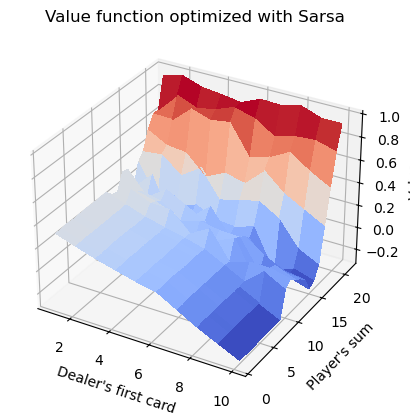

In [30]:
# Here we plot the value function optimized with TD control
V_TD = np.transpose(testTD.get_V())

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(1,11)
Y = np.arange(1,22)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
ax.set_xlabel("Dealer's first card")
ax.set_ylabel("Player's sum")
ax.set_zlabel('Value')
ax.title.set_text('Value function optimized with Sarsa')
ax.plot_surface(X, Y, V_TD,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

<Axes: xlabel="Player' sum", ylabel="Dealer's first card">

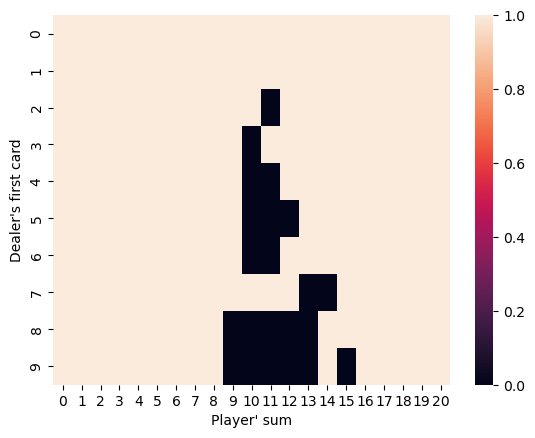

In [32]:
#The action map optimized with TD control. 0 represents hit and 1 represents stick.
actTD = np.zeros((10,21))
for i in range(10):
    for j in range(21):
        actTD[i,j] = np.argmax(testTD.Q[i,j])

ax = sns.heatmap(actTD)
ax.set(xlabel = "Player' sum", ylabel = "Dealer's first card")
ax

### Check convergence of Sarsa with different $\lambda$

In [35]:
#For different $\lambda$, we train the TD agent for 10^5 episodes and record the MSE after each episode.
testTD_mse = TDagent(Environment(), checkMSE=True)
l_set = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
TD_mse = {}
for l_try in l_set:
    testTD_mse.train(episodes=100000, l = l_try, optimal= testMC.Q)
    TD_mse[l_try] = testTD_mse.MSE

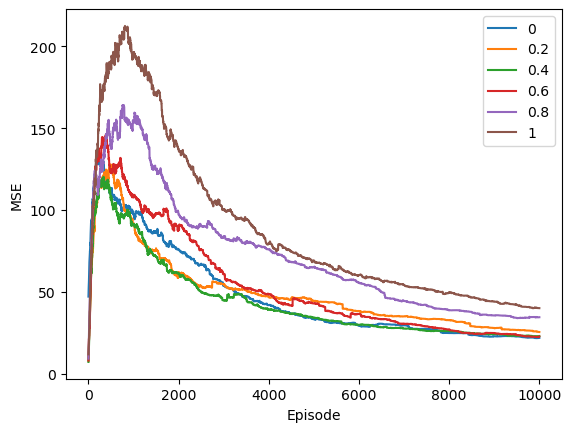

In [39]:
# Here we plot the MSE between TD action-value function and MC action-value function versus number of episode trained, with different $\lambda$
for l in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    plt.plot(np.arange(100000)[:10000], TD_mse[l][:10000], label = str(l))
plt.xlabel('Episode')
plt.ylabel('MSE')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


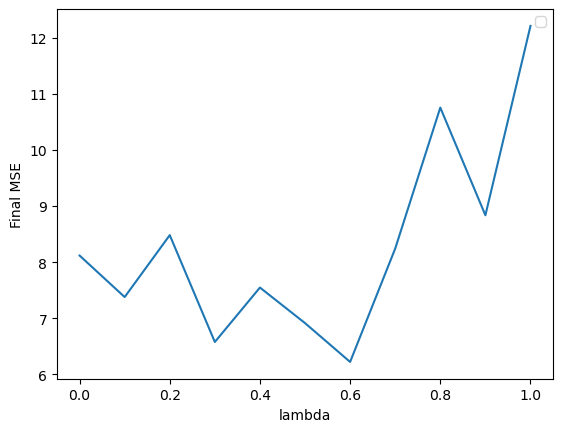

In [40]:
# We also plot here the MSE after 10^5 episodes versus the $\lambda$.
plt.plot(l_set, [TD_mse[l][-1] for l in TD_mse])
plt.xlabel("lambda")
plt.ylabel("Final MSE")
plt.legend()
plt.show()

# Linear function approximation (LFA) with Sarsa

## A little bit explanation

In previous sections, we discussed MC control and TD($\lambda$) control. However, in both cases, we have a look-up table for $Q(s,a)$ for all $(s,a)$. If the state-action space is large, it is not space efficient and search in the look-up table is also time-consuming. For large state-action space or even continuous state-action space, it is always easier to use a function approximation for $Q(s,a)$. Here, we consider the linear function approximation. Given a state-action vector $x(s,a)$, the action-value function is given by $Q(s,a;w) = w^T x(s,a)$. Here, $x(s,a)$ is a vector function of $(s,a)$ and $w$ is the weight vector for each feature.

To get the best weights $w$, we take the mse between the appoximate action-value function and the true action-value function as the cost function,
$$
J(w) = \mathbb{E}_\pi \Big[(Q_\pi(s,a) - Q(s,a;w))^2\Big].
$$
The SGD gives use the update rule:
$$
\Delta w = \alpha\Big[Q_\pi(s,a) - Q(s,a;w)\Big]\nabla_w Q(s,a;w) = \alpha\Big[Q_\pi(s,a) - Q(s,a;w)\Big]x(s,a).
$$
However, we don't know the true action-value function $Q_\pi(s,a)$. We could borrow the idea from the MC contorl or TD($\lambda$) control above. Here, we only consider the TD($\lambda$) control. Instead of using the true action-value function, we could replace it by the $\lambda$-return $q_t^\lambda$, which is an estimate of the ground truth. With the feature vector $x(s,a)$, the update of the eligibility trace is then $E_t\leftarrow \gamma\lambda E_{t-1} + \nabla Q(s,a;w)$. With these in mind, we can write down the algorithm

    Initialize w.
    Repeat (for each episode):
        E = 0.
        Initialize $(s,a)$ with epsilon-greedy policy.
        Repeat (for each step of episode):
            Take action a, observe r and s'.
            Choose a'  from s' using epsilon-greedy policy
            delta<- r + gamma*w^T*x(s',a') - w^T*x(s,a)
            E <- E + x(s,a)
            w <- w + alpha*delta*x(s,a)
            E <- gamma*lambda*E
            s<- s', a<- a'
        Until the episode terminates.

In the LFA, we choose constant step-size $\alpha = 0.01$ and constant $\epsilon = 0.05$.

## Experiments

We implement the same two experiments as we implemented in the TD control section. The feature vector is chosen as follows:

Each binary feature
has a value of $1$ iff $(s, a)$ lies within the cuboid of state-space corresponding to
that feature, and the action corresponding to that feature. The cuboids have
the following overlapping intervals:
$$
dealer(s) = \{[1, 4], [4, 7], [7, 10]\}\\
player(s) = \{[1, 6], [4, 9], [7, 12], [10, 15], [13, 18], [16, 21]\}\\
a = \{hit, stick\}
$$
where
1. dealer(s) is the value of the dealer’s first card (1–10)
2. sum(s) is the sum of the player’s cards (1–21)


### Check value function and action map with $\lambda = 0.5$

In [53]:
testLFA = LFAagent(Environment())
testLFA.train(2000000, l = 0.5)

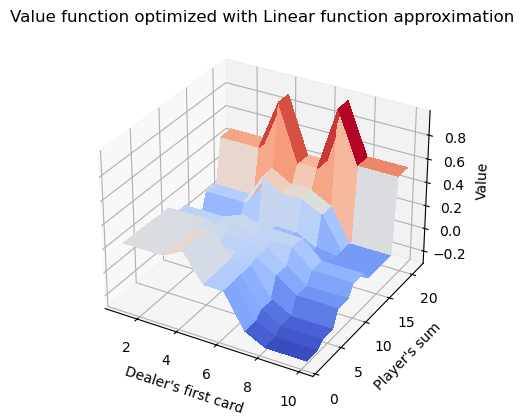

In [54]:
V_LFA = np.transpose(testLFA.get_V())

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.arange(1,11)
Y = np.arange(1,22)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
ax.set_xlabel("Dealer's first card")
ax.set_ylabel("Player's sum")
ax.set_zlabel('Value')
ax.title.set_text('Value function optimized with Linear function approximation')
ax.plot_surface(X, Y, V_LFA,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

<Axes: xlabel="Player' sum", ylabel="Dealer's first card">

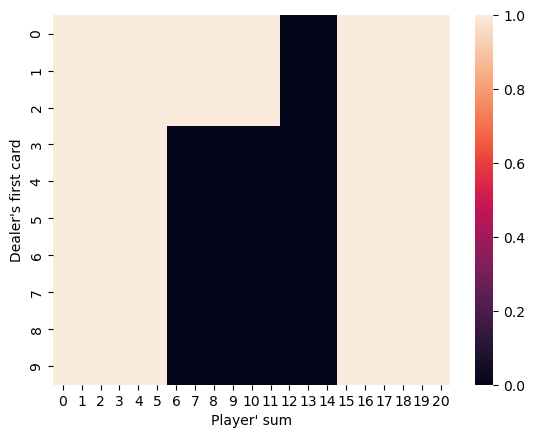

In [55]:
#The action map optimized with LFA Sarsa. 0 represents hit and 1 represents stick.
actLFA = np.zeros((10,21))
for i in range(10):
    for j in range(21):
        actLFA[i,j] = np.argmax(testLFA.Q_table()[i, j])

ax = sns.heatmap(actLFA)
ax.set(xlabel = "Player' sum", ylabel = "Dealer's first card")
ax

### Check convergence and MSE between LFA and MC

In [48]:
testLFA_mse = LFAagent(Environment(), checkMSE=True)
l_set = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
LFA_mse = {}
for l_try in l_set:
    testLFA_mse.train(numEpisode=30000, l = l_try, optimal= testMC.Q)
    LFA_mse[l_try] = testLFA_mse.MSE

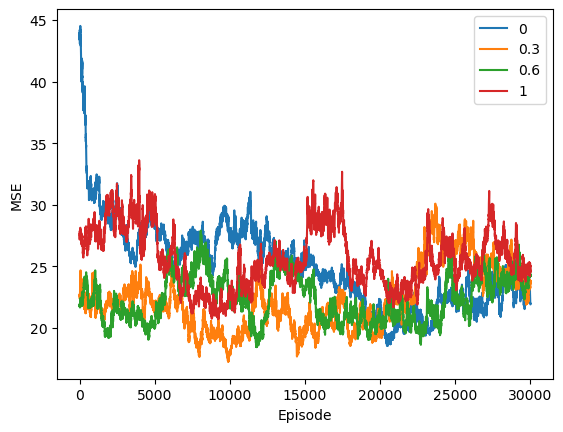

In [52]:
for l in [0, 0.3, 0.6, 1]:
    plt.plot(np.arange(100000)[:30000], LFA_mse[l][:30000], label = str(l))
plt.xlabel('Episode')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Play the game with the MC and LFA agents

In [62]:
## Test of MC agent
gameMC = Environment()

numGames = 1000000
resultMC = [0, 0] #[win, loss]
for game in range(numGames):
    gameMC.restart()
    while gameMC.playerSum:
        actNext = np.argmax(testMC.Q[gameMC.dealerFirst-1, gameMC.playerSum-1])
        gameMC.step(actNext)
    
    if gameMC.reward == 1:
        resultMC[0] += 1
    elif gameMC.reward == -1:
        resultMC[1] += 1

print("For", numGames, "games, the MC agent wins", resultMC[0], "games and loses", resultMC[1], 'games. The winning rate is', resultMC[0]/numGames)

For 1000000 games, the MC agent wins 525168 games and loses 471734 games. The winning rate is 0.525168


In [68]:
## Test of LFA agent
gameLFA = Environment()
LFA_Q = testLFA.Q_table()

numGames = 1000000
resultLFA = [0, 0] #[win, loss]
for game in range(numGames):
    gameLFA.restart()
    while gameLFA.playerSum:
        actNext = np.argmax(LFA_Q[gameLFA.dealerFirst-1, gameLFA.playerSum-1])
        gameLFA.step(actNext)
    
    if gameLFA.reward == 1:
        resultLFA[0] += 1
    elif gameLFA.reward == -1:
        resultLFA[1] += 1

print("For", numGames, "games, the LFA agent wins", resultLFA[0], "games and loses", resultLFA[1], 'games. The winning rate is', resultLFA[0]/numGames)

For 1000000 games, the LFA agent wins 518896 games and loses 468614 games. The winning rate is 0.518896
